In [1]:
%load_ext jupyter_black
import nest_asyncio

nest_asyncio.apply()

In [2]:
from datetime import datetime, timedelta
import xarray as xr
from pathlib import Path
from griblib import extract

store = Path.cwd().parent / "store"

In [6]:
def main():
    start = datetime.fromisoformat("2022-03-01")
    for _ in range(120):
        end = start + timedelta(days=1)
        print(start, end)
        ds = extract.gmgsi(start, start + timedelta(days=1), "GMGSI_LW")
        kwargs = {}
        if store.exists():
            kwargs = {"mode": "a", "append_dim": "time"}

        ds.to_zarr(store, **kwargs)

        start = end


if __name__ == "__main__":
    main()

2022-03-01 00:00:00 2022-03-02 00:00:00
2022-03-02 00:00:00 2022-03-03 00:00:00
2022-03-03 00:00:00 2022-03-04 00:00:00
2022-03-04 00:00:00 2022-03-05 00:00:00
2022-03-05 00:00:00 2022-03-06 00:00:00
2022-03-06 00:00:00 2022-03-07 00:00:00
2022-03-07 00:00:00 2022-03-08 00:00:00
2022-03-08 00:00:00 2022-03-09 00:00:00
2022-03-09 00:00:00 2022-03-10 00:00:00
2022-03-10 00:00:00 2022-03-11 00:00:00
2022-03-11 00:00:00 2022-03-12 00:00:00
2022-03-12 00:00:00 2022-03-13 00:00:00
2022-03-13 00:00:00 2022-03-14 00:00:00
2022-03-14 00:00:00 2022-03-15 00:00:00
2022-03-15 00:00:00 2022-03-16 00:00:00
2022-03-16 00:00:00 2022-03-17 00:00:00
2022-03-17 00:00:00 2022-03-18 00:00:00
2022-03-18 00:00:00 2022-03-19 00:00:00
2022-03-19 00:00:00 2022-03-20 00:00:00
2022-03-20 00:00:00 2022-03-21 00:00:00
2022-03-21 00:00:00 2022-03-22 00:00:00
2022-03-22 00:00:00 2022-03-23 00:00:00
2022-03-23 00:00:00 2022-03-24 00:00:00
2022-03-24 00:00:00 2022-03-25 00:00:00
2022-03-25 00:00:00 2022-03-26 00:00:00


ClientConnectorError: Cannot connect to host noaa-gmgsi-pds.s3.amazonaws.com:443 ssl:default [Connect call failed ('52.216.86.203', 443)]


da.shape=(5, 3000, 4999)
len(lat)=3000
len(lon)=4999



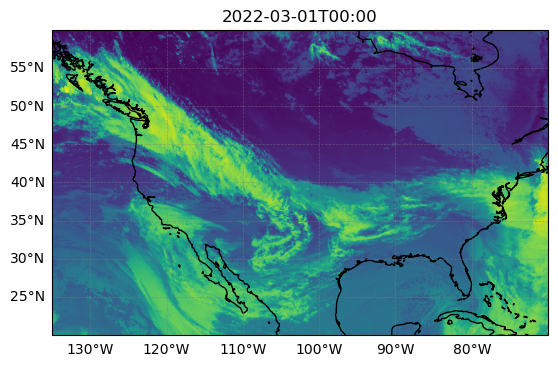

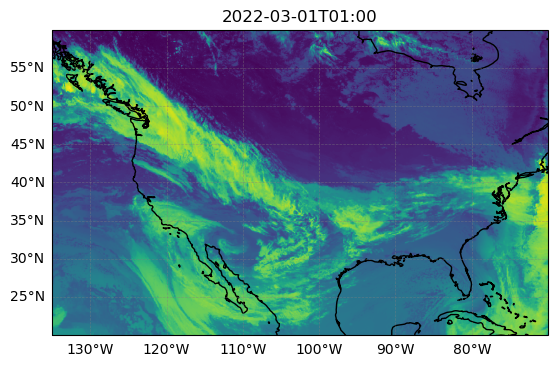

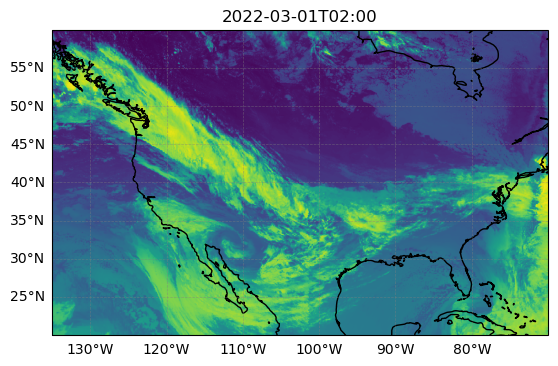

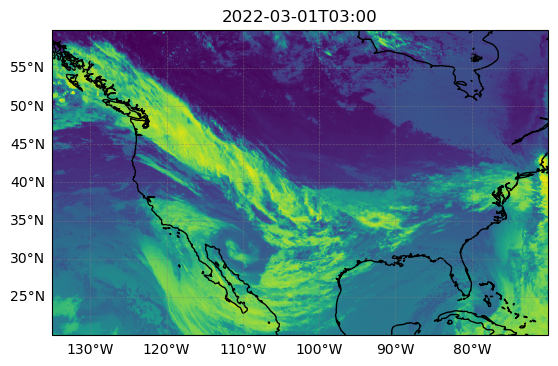

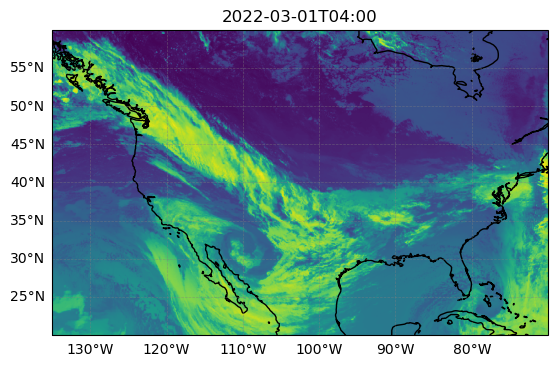

In [61]:
%matplotlib inline
from dataclasses import dataclass
from sqlite3 import Timestamp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.geoaxes import GeoAxes


class DataArray(xr.DataArray):
    __slots__ = []
    time: xr.DataArray
    lon: xr.DataArray
    lat: xr.DataArray


class GeoSatilite:
    """Global Mosaic of Geostationary Satellite Imagery"""

    img_extent = (-180, 180, -90, 90)
    values: DataArray

    def __init__(self, ds: DataArray) -> None:
        self.values = ds

    @classmethod
    def from_zarr(self, store: Path) -> "GeoSatilite":
        ds = xr.open_zarr(store)
        return GeoSatilite(ds["data"])

    def axes(self, projection=ccrs.PlateCarree()) -> GeoAxes:
        return plt.axes(projection=projection)

    def imshow(
        self,
        time=0,
        lats=...,
        lons=...,
    ) -> None:
        fig = plt.figure(figsize=(12, 6))
        ax = self.axes()
        ax.imshow(self.values[time, lats, lons], extent=self.img_extent)
        ax.coastlines(resolution="auto")
        ax.gridlines()

def geoaxes(projection=ccrs.PlateCarree()) -> GeoAxes:
    return plt.axes(projection=projection)


@dataclass
class Extent:
    min_x: float
    max_x: float
    min_y: float
    max_y: float

    def __iter__(self):
        yield from self.__dict__.values()

ds = xr.open_zarr(store)
da = ds["data"][:5, :, :]
lat, lon = (np.unique(da[key]) for key in ("lat", "lon"))

print(
    f"""
{da.shape=}
{len(lat)=}
{len(lon)=}
"""
)

extent = Extent(-135, -70, 20, 60)

lat_mask = (lat > extent.min_y) & (lat < extent.max_y)
lon_mask = (lon > extent.min_x) & (lon < extent.max_x)

for label, arr in da.drop(["lat", "lon"]).sel({"yc": lat_mask, "xc": lon_mask}).groupby("time"):
    fig = plt.figure(label)
    ax = geoaxes()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(label.astype("datetime64[m]"))
    ax.imshow(arr, extent=tuple(extent))
    ax.coastlines(resolution="auto")

In [44]:
from dataclasses import dataclass

N, E, S, W = 60, -70, 20, -135


@dataclass
class Extent:
    min_x: float
    max_x: float
    min_y: float
    max_y: float

    def __iter__(self):
        yield from self.__dict__.values()


extent = Extent(60, -70, 20, -135)
tuple(extent)

(60, -70, 20, -135)

In [ ]:
import asyncio
import aiohttp
from typing import Literal


class URLTemplate(str):
    def __new__(
        cls: type["URLTemplate"], prod: Literal["GMGSI_LW", "GMGSI_SSR", "GMGSI_SW", "GMGSI_VIS", "GMGSI_WV"]
    ) -> "URLTemplate":

        key = {
            "GMGSI_LW": "GLOBCOMPLIR_nc",
            "GMGSI_SSR": "GLOBCOMPSSR_nc",
            "GMGSI_SW": "GLOBCOMPSIR_nc",
            "GMGSI_VIS": "GLOBCOMPVIS_nc",
            "GMGSI_WV": "GLOBCOMPWV_nc",
        }
        cls.value = str(f"https://noaa-gmgsi-pds.s3.amazonaws.com/{prod}/%Y/%m/%d/%H/{key[prod]}.%Y%m%d%H")
        # setattr(value, "to_daterange", ...)
        # value.to_daterange = lambda x: x
        return cls

    # URLTemplate("GMGSI_WV")
    @classmethod
    @property
    def water_vapor(cls):
        return cls("GMGSI_WV")

    def __str__(self) -> str:
        return self.value

    # water_vapor = __new__(object, "GMGSI_WV")


import pandas as pd

URLTemplate("GMGSI_WV")
url_template = URLTemplate("GMGSI_WV")
urls = pd.date_range("2022-03-01T00", "2022-03-01T02", freq="H").strftime(url_template)

TypeError: Argument 'format' has incorrect type (expected str, got type)

In [ ]:
from datetime import datetime
import netCDF4
import requests
import pandas as pd
import aiohttp
import uuid
from pathlib import Path
import xarray as xr
import contextlib

TMP = Path("/tmp")


def get_url_template(prod: Literal["GMGSI_LW", "GMGSI_SSR", "GMGSI_SW", "GMGSI_VIS", "GMGSI_WV"]):
    key = {
        "GMGSI_LW": "GLOBCOMPLIR_nc",
        "GMGSI_SSR": "GLOBCOMPSSR_nc",
        "GMGSI_SW": "GLOBCOMPSIR_nc",
        "GMGSI_VIS": "GLOBCOMPVIS_nc",
        "GMGSI_WV": "GLOBCOMPWV_nc",
    }
    return f"https://noaa-gmgsi-pds.s3.amazonaws.com/{prod}/%Y/%m/%d/%H/{key[prod]}.%Y%m%d%H"


async def my_tempfile(result: bytes) -> Path:
    tmp_file = TMP / str(uuid.uuid1())
    with tmp_file.open("wb") as tmp:
        tmp.write(result)
    return tmp_file


async def fetch_path(session: aiohttp.ClientSession, url: list[str]) -> Path:
    async with session.get(url) as r:
        if r.status == 200:
            return await my_tempfile(await r.read())
        print(f"error downloading {url}")


async def fetch_all_paths(session: aiohttp.ClientSession, urls: list[str]) -> list[Path]:
    tasks = []
    for url in urls:
        task = asyncio.create_task(fetch_path(session, url))
        tasks.append(task)
    return await asyncio.gather(*tasks)


async def main(urls: list[str]) -> list[Path]:
    async with aiohttp.ClientSession() as session:
        return await fetch_all_paths(session, urls)


def gmgsi(
    start: str, stop: str, product: Literal["GMGSI_LW", "GMGSI_SSR", "GMGSI_SW", "GMGSI_VIS", "GMGSI_WV"] = "GMGSI_WV"
):
    url_template = URLTemplate(product)
    urls = pd.date_range(start, stop, freq="H").strftime(get_url_template(product))
    paths = asyncio.run(main(urls))
    ds = xr.open_mfdataset(paths, engine="netcdf4", concat_dim="time", combine="nested")
    for path in paths:
        path.unlink()
    return ds


if __name__ == "__main__":
    ds = gmgsi(
        "2022-03-01T00",
        "2022-03-01T02",
    )
ds

<xarray.Dataset>
Dimensions:  (time: 3, yc: 3000, xc: 4999)
Coordinates:
    lat      (yc, xc) float32 dask.array<chunksize=(3000, 4999), meta=np.ndarray>
    lon      (yc, xc) float32 dask.array<chunksize=(3000, 4999), meta=np.ndarray>
  * time     (time) datetime64[ns] 2022-03-01 ... 2022-03-01T02:00:00
Dimensions without coordinates: yc, xc
Data variables:
    data     (time, yc, xc) float32 dask.array<chunksize=(1, 3000, 4999), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.4
    Source:               McIDAS Area File
    Satellite Sensor:     DERIVED DATA
    time_coverage_start:  2022-03-01T00:00:00
    instrument_name:      GLOBCOMPWV
    history:              Tue Mar  1 00:34:19 2022: ncks -d xc,0,4998 tempo.n...
    NCO:                  netCDF Operators version 4.7.5 (Homepage = http://n...

In [ ]:
ds.to_dataframe()

data        lat         lon
time                yc   xc                                
2022-03-01 00:00:00 0    0     155.0  72.715408  179.999619
                         1     154.0  72.715408 -179.928375
                         2     154.0  72.715408 -179.856369
                         3     154.0  72.715408 -179.784363
                         4     154.0  72.715408 -179.712357
...                              ...        ...         ...
2022-03-01 02:00:00 2999 4994  138.0 -72.736771  179.612350
                         4995  133.0 -72.736771  179.684357
                         4996  133.0 -72.736771  179.756363
                         4997  138.0 -72.736771  179.828369
                         4998  110.0 -72.736771  179.900375

[44991000 rows x 3 columns]

In [ ]:
import xarray as xr
import io
import netCDF4 as nc
import tempfile
import os
import tempfile
from contextlib import contextmanager
@contextmanager
def doit(r:requests.Response, engine="netcdf4"):
    fd, path = tempfile.mkstemp()

    try:
        with open(path, 'wb') as tmp:
            # do stuff with temp file
            tmp.write(r.content)
        yield xr.open_dataset(path, engine=engine).to_dataframe()
    finally:
        os.remove(path)

with doit(r) as ds:
    print(ds)


                       data        lat         lon
time       yc   xc                                
2022-03-01 0    0     155.0  72.715408  179.999619
                1     154.0  72.715408 -179.928375
                2     154.0  72.715408 -179.856369
                3     154.0  72.715408 -179.784363
                4     154.0  72.715408 -179.712357
...                     ...        ...         ...
           2999 4994  155.0 -72.736771  179.612350
                4995  158.0 -72.736771  179.684357
                4996  158.0 -72.736771  179.756363
                4997  161.0 -72.736771  179.828369
                4998  163.0 -72.736771  179.900375

[14997000 rows x 3 columns]
